# ITT 2023 LNLS: Compresed Sensing (CS) Challenge
## CS applied to FTIR at LNLS IMBUIA Beamline 

In [1]:
import numpy
import pandas 
import matplotlib.pyplot as plt
from scipy.optimize import minimize as scipy_minimize
from scipy.fft import fft, ifft
import random
from scipy.optimize import linprog

# Read IMBUIA data

### Air interferogram and Spectrum computed by FTIR software

In [2]:
# Escrever um string com o caminho para o dado na pasta do google drive
path = 'data/'

# Name .csv file
name_espectrum_air = 'ar_ATR_spectrum.csv'
name_interferogram_air = 'ar_atr_interf.csv'

data_air_spectrum = pandas.read_csv(path+name_espectrum_air, header=None)
data_air_spectrum = numpy.asarray(data_air_spectrum)

data_air_interf = pandas.read_csv(path+name_interferogram_air, header=None)
data_air_interf = numpy.asarray(data_air_interf)

transmission_air = numpy.exp(-data_air_spectrum[:,1])

# All the data is written as follows:
#
#
# n_points: number of acquired points
# interferogram.shape = (n_points_interf, 4)
# interferogram: column 0 - x-direction - Optical path [cm]
# interferogram: column 1 - y-direction - Voltz [V]
# ---------------------------------------------------
# spectrum.shape = (n_points_spectrum, 2)
# spectrum: column 0 - x-direction - Frequency [1/cm]
# spectrum: column 1 - y-direction - Absorption

### Plot interferogram and spectrum

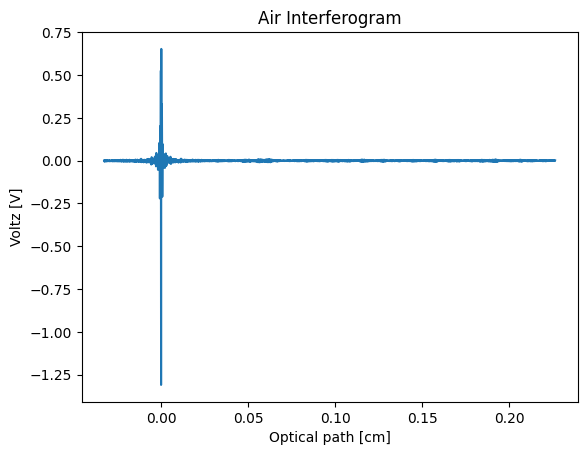

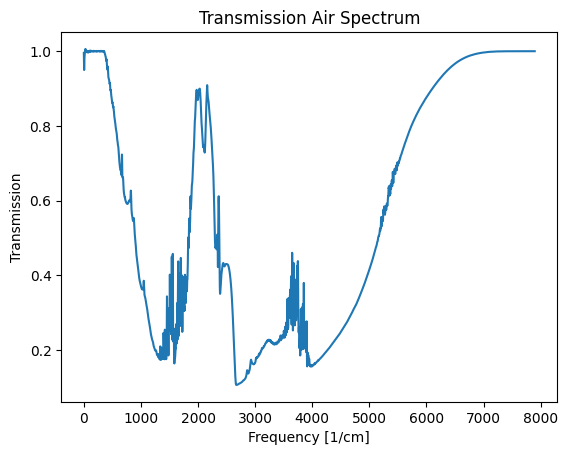

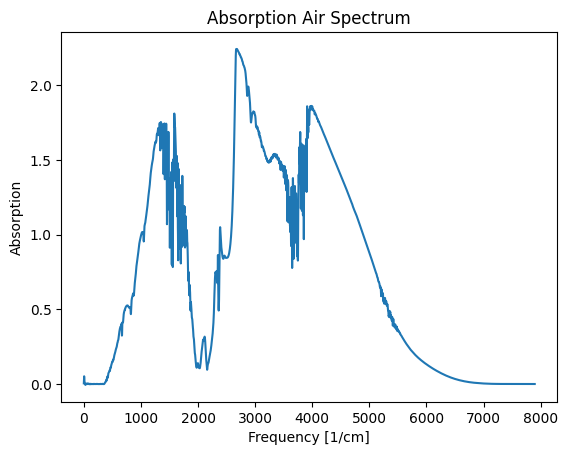

In [27]:
plt.figure(0)
plt.plot(data_air_interf[:,0],data_air_interf[:,1])
plt.xlabel('Optical path [cm]')
plt.ylabel('Voltz [V]')
plt.title('Air Interferogram')

plt.figure(1)
plt.plot(data_air_spectrum[:,0],transmission_air)
plt.xlabel('Frequency [1/cm]')
plt.ylabel('Transmission')
plt.title('Transmission Air Spectrum')

plt.figure(2)
plt.plot(data_air_spectrum[:,0],data_air_spectrum[:,1])
plt.xlabel('Frequency [1/cm]')
plt.ylabel('Absorption')
plt.title('Absorption Air Spectrum')

plt.show()

### Simulated Problem

In [86]:
spec_cutoff = 20
specs_x = numpy.arange(spec_cutoff)
percent = 0.85
N       = 1024
M       = int(N*percent)

# Set spectrum :
t        = numpy.linspace(-1,1, 2 * N - 2)
interferogram = 5*numpy.cos(2*numpy.pi*t) - 7*numpy.cos(4*numpy.pi*t) + 11*numpy.cos(6*numpy.pi*t)

# DFT Complex matrix
D = fft.fft(numpy.eye(N), 1).real
iD = fft.irfft(numpy.eye(N)).real

# Get interferogram
spectrum = numpy.dot(iD, interferogram).real

# Plot
plt.figure(3)
plt.plot(numpy.fft.fftshift(interferogram))
plt.title('Simulated Interferogram')

plt.figure(4)
plt.bar(x=specs_x, height=spectrum[:spec_cutoff])
plt.title('Simulated spectrum')

plt.show()

AttributeError: 'uarray._Function' object has no attribute 'fft'

In [41]:
numpy.linalg.norm(D @ D.T - numpy.eye(N)) 

31.984371183438952


## Select M sample datapoints from interferogram

### M data points and M rows of DFT matrix

D shape: (2046, 1024)
iD shape: (1024, 2046)
spectrum shape: (1024,)
interferogram shape: (2046,)
N: 1024
M: 61
A shape: (61, 1024)
B shape: (1024, 61)
interfero shape: (61,)


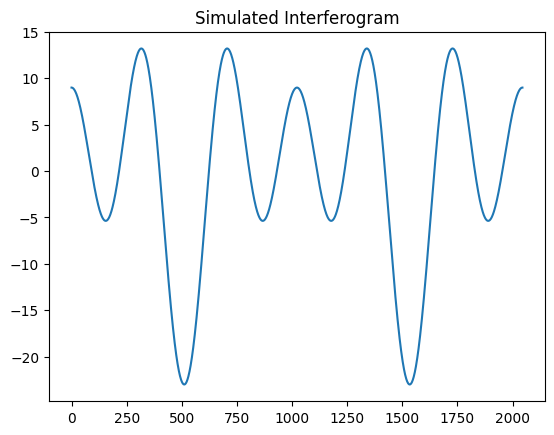

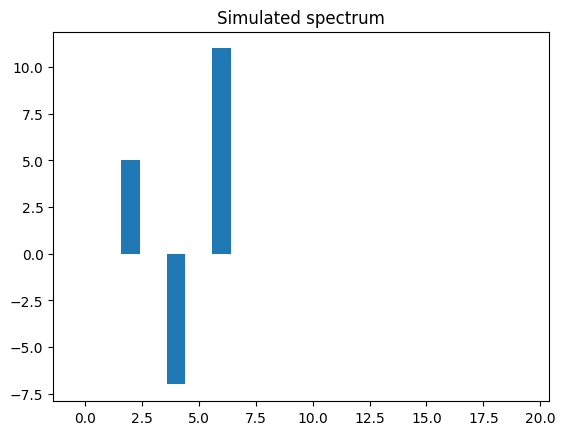

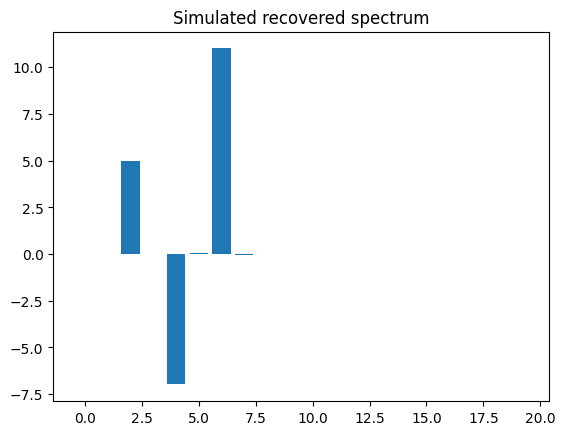

In [194]:
percent = 0.06
N       = 1024
M       = int(N*percent)

# Set Simulated Spectrum:
t        = numpy.linspace(-1,1, 2*N - 2)
interferogram = 5*numpy.cos(2*numpy.pi*t) - 7*numpy.cos(4*numpy.pi*t) + 11*numpy.cos(6*numpy.pi*t)

# Real DFT matrix
D  = numpy.fft.rfft(numpy.eye(2*N - 2)).real 
iD = numpy.fft.irfft(numpy.eye(N)).real

spectrum = numpy.zeros(N)
spectrum[[2, 4, 6]] = 5, -7, 11

print('D shape:', D.shape)
print('iD shape:', iD.shape)
print('spectrum shape:', spectrum.shape)
print('interferogram shape:', interferogram.shape)

espectrum_from_interferogram = numpy.dot(iD,interferogram)

# Choose M random rows of D (DFT)
rows_id = numpy.random.choice(2*N - 2,size=M,replace=False)
rows_id.sort()

A = numpy.zeros((M,N))

interfero = numpy.zeros(M)

for i in range(M):
    A[i]          = D[rows_id[i],:] # select M row of DFT matrix D
    interfero[i]  = interferogram[rows_id[i]] # select M datapoints of interferogram

B = A.conjugate().transpose() # select M columns of iDFT matrix iD

print('N:', N)
print('M:', M)

print('A shape:', A.shape)
print('B shape:', B.shape)
print('interfero shape:', interfero.shape)


plt.figure(5)
plt.plot(interferogram)
plt.title('Simulated Interferogram')

plt.figure(6)
plt.bar(x=specs_x, height=spectrum[:spec_cutoff])
plt.title('Simulated spectrum')

plt.figure(7)
plt.bar(x=specs_x,height= espectrum_from_interferogram[:spec_cutoff])
plt.title('Simulated recovered spectrum')

plt.show()

### Initial example solving the CS problem by linear programming

In [195]:
def get_s(A, y):
    # Initial example of linear programming function to solve the Compressed sensing problem for FTIR

    x_dim, y_dim = A.shape[1], y.shape[0]

    obj = numpy.ones(2*x_dim)

    lhs_eq = numpy.concatenate((A, -A), axis=1)
    rhs_eq = y

    bnd = [*((0.0, None) for _ in range(2*x_dim))]

    res = linprog(c=obj, A_eq=lhs_eq, b_eq=rhs_eq, bounds=bnd, method="revised simplex")

    return res.x[:x_dim] - res.x[x_dim:]


In [196]:
#solution = get_s(A, spectrum)
solution = get_s(A, interfero)
# print(solution.sum())

/var/folders/_b/3kv60l2n3xz0kgr__6tfxd_00000gn/T/ipykernel_67976/1430578990.py:13: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(c=obj, A_eq=lhs_eq, b_eq=rhs_eq, bounds=bnd, method="revised simplex")


In [197]:
solution[:20]

array([-1.79582901e-02,  3.72415949e-04,  5.00795926e+00,  0.00000000e+00,
       -6.97041501e+00,  1.35525272e-20,  1.09561600e+01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.61476034e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [198]:
D2 = numpy.fft.fft(numpy.eye(N)) / numpy.sqrt(N)

In [199]:
D2.shape

(1024, 1024)

In [200]:
numpy.linalg.norm((D2.T @ D2) - numpy.eye(N))

45.21061822182926

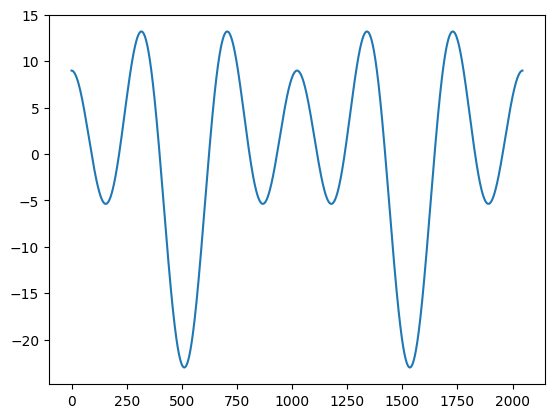

In [201]:
plt.plot(D @ spectrum)

### Plot and compare solutions

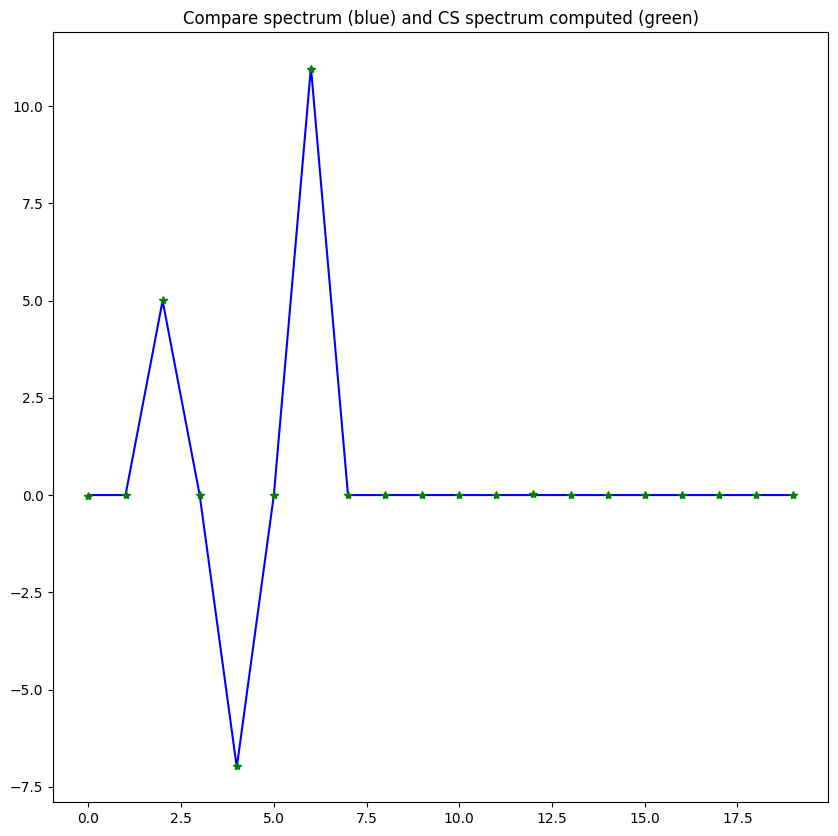

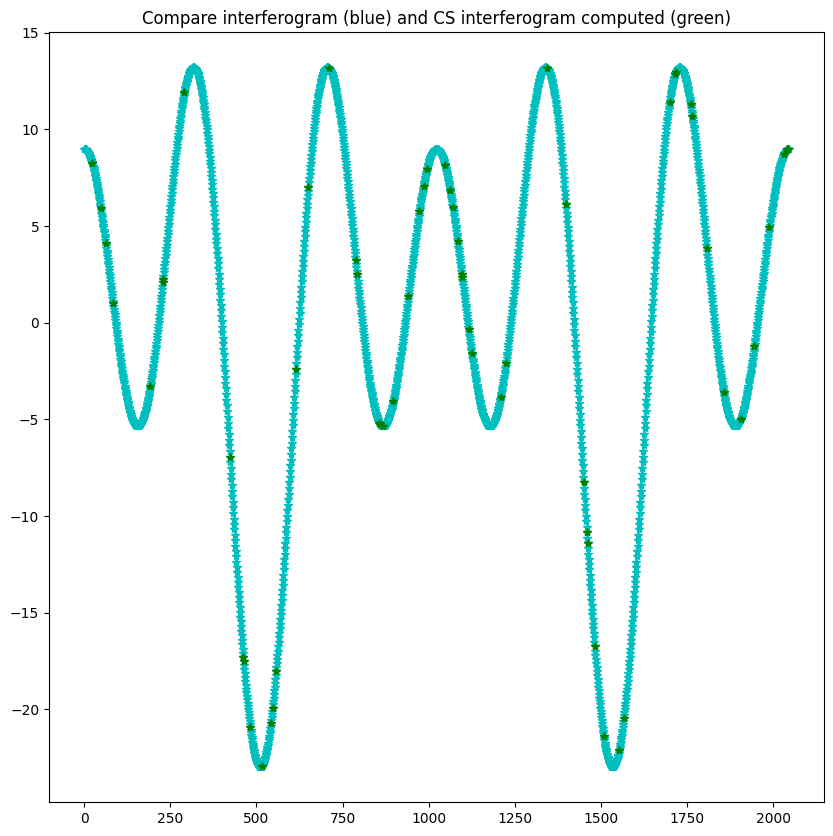

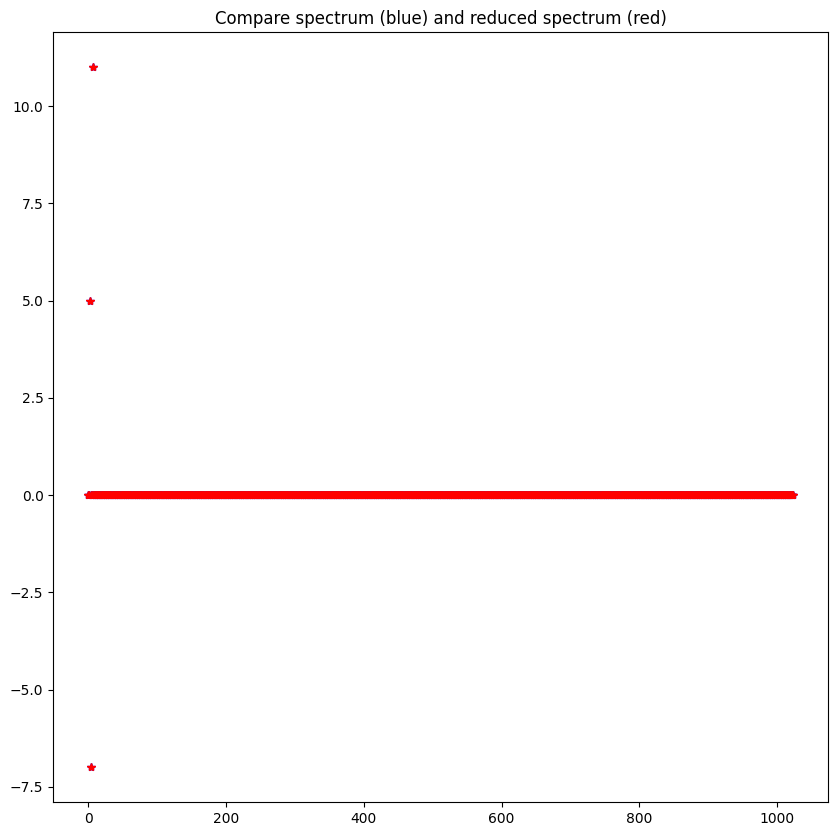

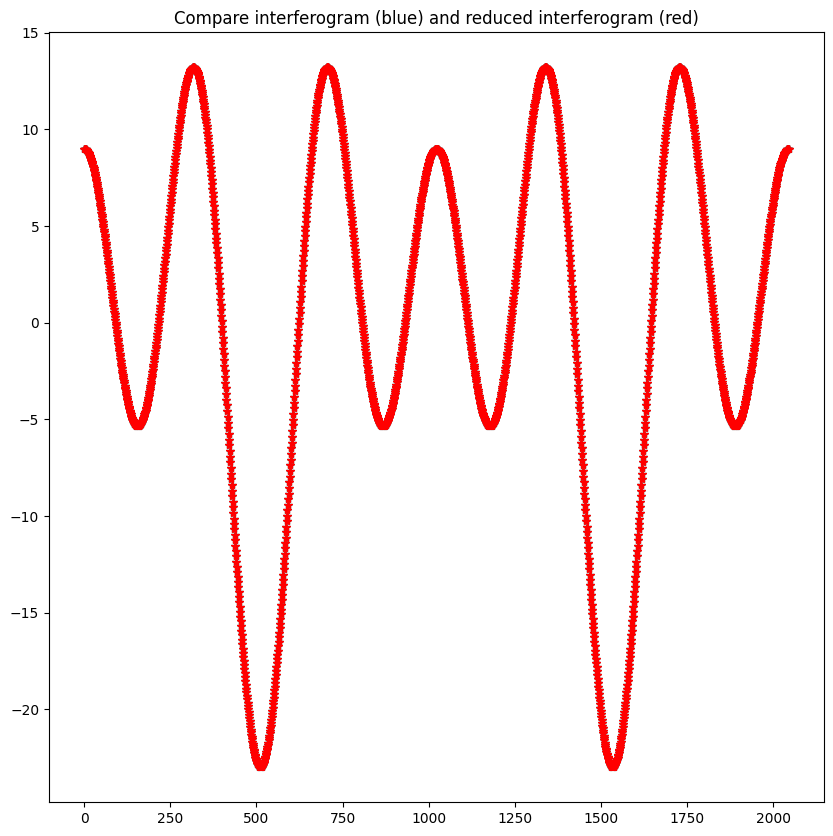

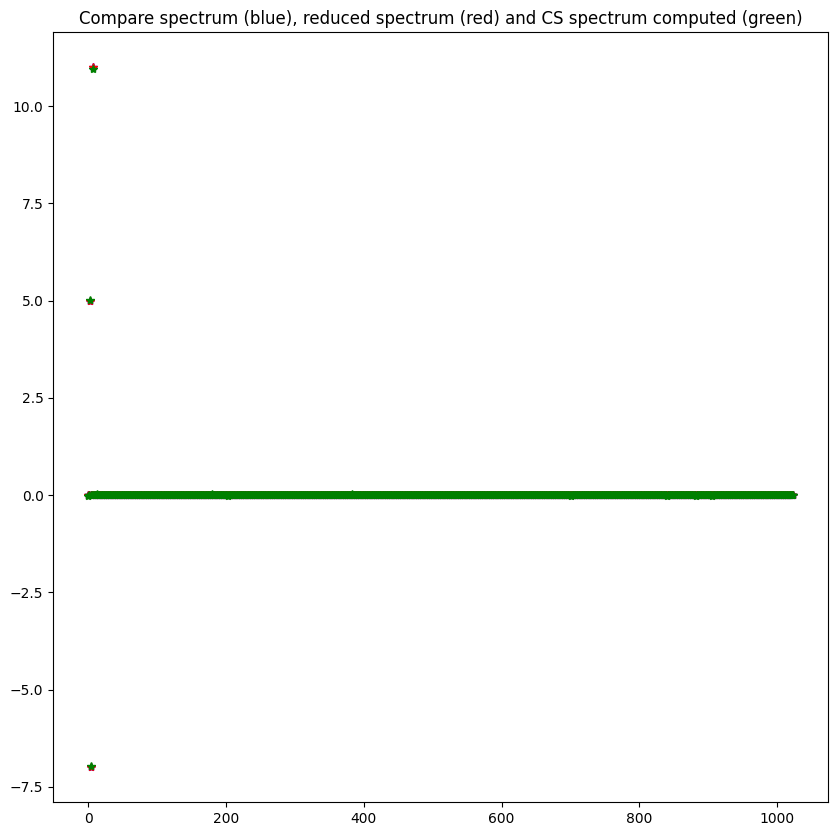

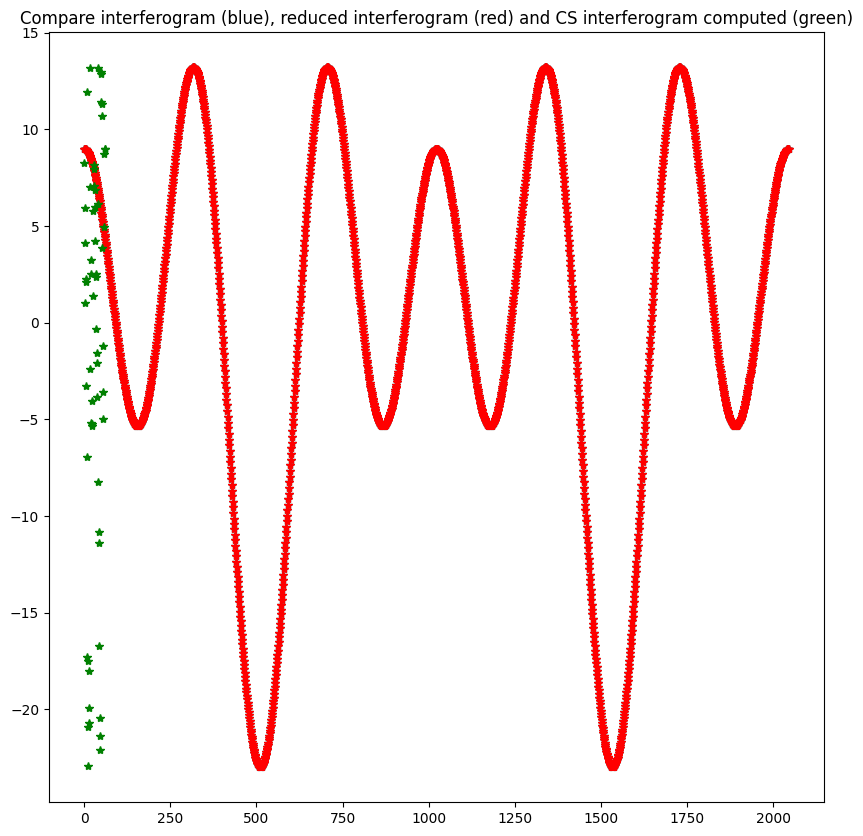

In [202]:
# Computed simulated solutions
interferogram_computed = numpy.dot(A,solution)
spectrum_computed      = solution

# Provided solutions

interf = interferogram # (numpy.dot(D,spectrum))
spec   = spectrum # (numpy.dot(B,interf))

# Plots
plt.figure(8, figsize=(10,10))
plt.plot(spectrum[:spec_cutoff],'b',spectrum_computed[:spec_cutoff],'g*')
plt.title('Compare spectrum (blue) and CS spectrum computed (green)')

plt.figure(9, figsize=(10,10))
plt.plot(interferogram,'c*')
plt.plot(rows_id, interferogram_computed,'g*')
plt.title('Compare interferogram (blue) and CS interferogram computed (green)')

plt.figure(10, figsize=(10,10))
plt.plot(spectrum,'b*',spec,'r*')
plt.title('Compare spectrum (blue) and reduced spectrum (red)')

plt.figure(11, figsize=(10,10))
plt.plot(interferogram,'c*',interf,'r*')
plt.title('Compare interferogram (blue) and reduced interferogram (red)')

plt.figure(12, figsize=(10,10))
plt.plot(spectrum,'b*',spec,'r*',spectrum_computed,'g*')
plt.title('Compare spectrum (blue), reduced spectrum (red) and CS spectrum computed (green)')

plt.figure(13, figsize=(10,10))
plt.plot(interferogram,'c*',interf,'r*',interferogram_computed,'g*')
plt.title('Compare interferogram (blue), reduced interferogram (red) and CS interferogram computed (green)')

plt.show()





In [84]:
N = 10
D2 = numpy.fft.fft(numpy.eye(N)).real / numpy.sqrt(N)
numpy.linalg.norm(D2.conjugate().transpose() @ D2 - numpy.eye(N))


2.0

### Infra red database reading



In [22]:
import os
import pandas as pd
from jcamp import jcamp_readfile
nist_data = '../data/nist_data/'
jcamp_molecules = os.listdir(nist_data)

def jcamp_to_csv(jcamp_file):
    jcamp_dict = jcamp_readfile(jcamp_file)
    x = jcamp_dict['x']
    y = jcamp_dict['y']
    title = jcamp_dict['title']
    df = pd.DataFrame(jcamp_dict, columns=['x', 'y'])
    df.to_csv(jcamp_file[:-4]+'_'+title+'.csv', index=False)

for file in jcamp_molecules:
    if file.endswith('.csv'):
        continue
    jcamp_to_csv(nist_data+file)


In [17]:
jcamp_dict = jcamp_readfile(nist_data+"63148-62-9-IR_Re.jdx")
jcamp_dict.keys()

dict_keys(['title', 'jcamp-dx', 'data type', 'origin', 'owner', 'date', 'cas registry no', 'molform', '$nist source', '$nist doc file', 'spectrometer/data system', 'instrument resolution', 'ir source', 'aperture', 'beamsplitter', 'detector', 'scanner speed', 'phase correction', 'interferogram zerofill', 'spectral interval after zerofilling', 'spectral range', 'state', 'resolution', 'apodization', 'folding limits', 'number of interferograms averaged per single channel spectrum', 'xunits', 'yunits', 'ylabel', 'xfactor', 'yfactor', 'deltax', 'firstx', 'lastx', 'firsty', 'maxx', 'minx', 'maxy', 'miny', 'npoints', 'xydata', 'end', 'x', 'y', 'filename'])

In [18]:
jcamp_dict["x"].shape, jcamp_dict["y"].shape

((15345,), (15345,))

In [19]:
jcamp_dict["x"]

array([7797.62      , 7797.13857143, 7796.65714286, ...,  400.640958  ,
        400.157944  ,  399.67493   ])

In [20]:
import matplotlib.pylab as plt

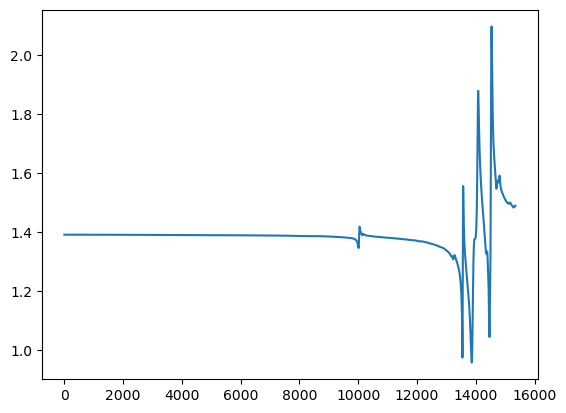

In [21]:
plt.plot(jcamp_dict["y"])